# **Facial Recognition**

## **Requirements**

In [70]:
import sys
import os
from PIL import Image
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import  product
from sklearn.model_selection import train_test_split
from itertools import product
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [73]:
from FacialRecognition import FacialRecognitionKnn, RandomSearchFacialRecognitionKnn, FacialRecognitionKnnPca, RandomSearchFacialRecognitionKnnPca, FacialRecognitionKnnPcaFisher, RandomSearchFacialRecognitionKnnPcaFisher

In [74]:
def load_images(folder, image_size=None, convert_to_gray=True, output='numpy'):

    # image_size = (width, height)
    images_list = []
    
    for filename in os.listdir(folder):
    
        if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
    
            img = Image.open(os.path.join(folder, filename))
    
            if image_size == None :
                image_size = img.size

            img = img.resize(image_size)

            if convert_to_gray == True :
                img = img.convert('L')  # Convert to grayscale
            
            img_array = np.array(img)
            img_vector = img_array.flatten() # image as an observation (1D array)
            images_list.append(img_vector)
            images_array = np.array(images_list)

    if  output == 'numpy' :
    
        images_dataset = images_array

    elif output == 'polars' :
        
        width = image_size[0]
        height = image_size[1] 
        images_dataset = pl.DataFrame(images_array)
        if convert_to_gray == True :
            images_dataset.columns = [f'pixel_{i}_{j}' for i in range(1,height+1) for j in range(1,width+1)] 
        else :
            x = list()
            for (i,j) in product(range(1,height+1), range(1,width+1)) :
                x = x + [f'{channel}_{i}_{j}' for channel in ['R', 'G', 'B']]
            images_dataset.columns = x 
    
    return images_dataset

## **Data**

### **Images of people of our database (IN people)**

In [75]:
folder = r"C:\Users\fscielzo\Documents\Large-Data\Face_Recognition_Data\IN_images"
X_IN = load_images(folder=folder, image_size=(180,200), convert_to_gray=True, output='numpy')

n_images_per_person = 6
n_people_db = 25

Y_IN = np.array([])
for i in range(1, n_people_db+1) :
    arr = np.repeat(i, n_images_per_person)
    Y_IN = np.concatenate((Y_IN, arr))

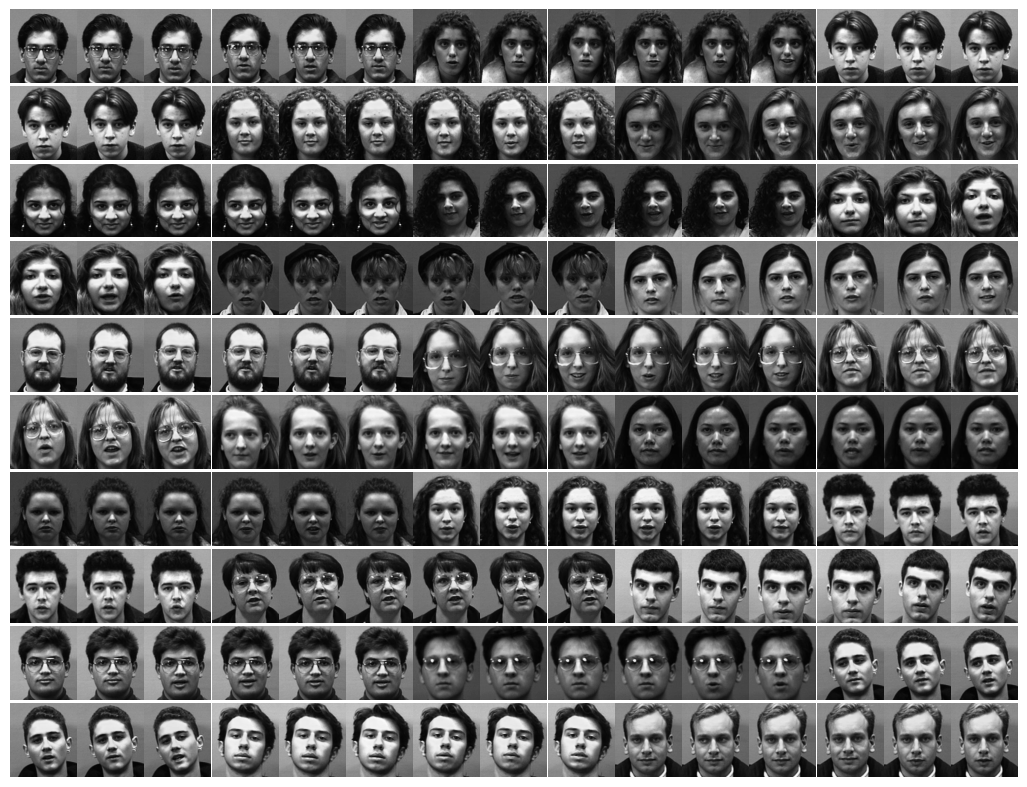

In [76]:
n_images = len(X_IN) 
height = 200
width = 180
# This is critical, if it is incorrect, images will be distorted.
image_size = (height, width) 
n_cols = 15
n_rows = int(np.ceil(n_images/n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(13, 10))
axes = axes.flatten() 
for i in range(n_images):
        image_vector = X_IN[i, :]
        reshaped_image = image_vector.reshape(image_size)
        axes[i].imshow(reshaped_image, cmap='gray')
        axes[i].axis('off')
plt.subplots_adjust(hspace=0.01, wspace=0.01) 
for j in range(n_images, n_rows * n_cols):
    fig.delaxes(axes[j])
plt.show()

### **Images of external people (OUT people)**

In [77]:
folder = r"C:\Users\fscielzo\Documents\Large-Data\Face_Recognition_Data\OUT_Images"
X_OUT = load_images(folder=folder, image_size=(180,200), convert_to_gray=True, output='numpy')
Y_OUT = np.repeat(0, len(X_OUT))

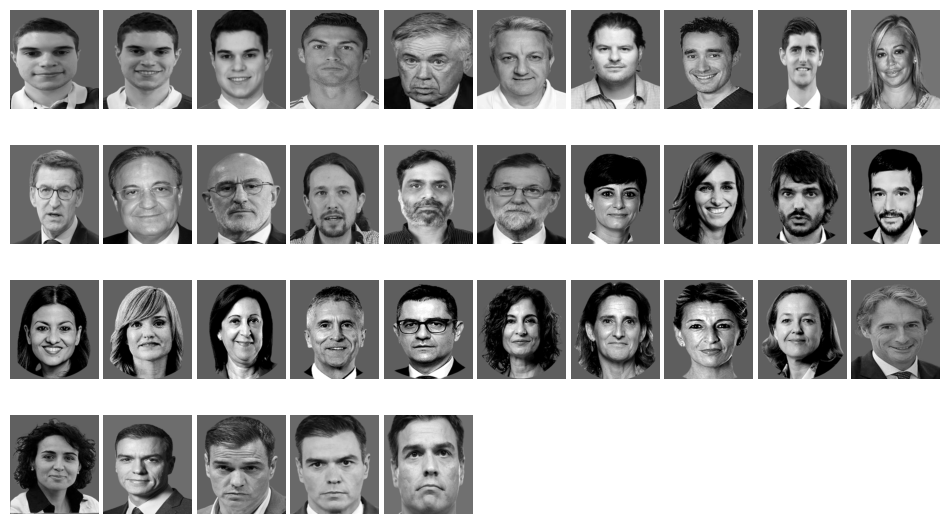

In [78]:
n_images = len(X_OUT) 
height = 200
width = 180
image_size = (height, width) 
n_cols = 10
n_rows = int(np.ceil(n_images/n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 7))
axes = axes.flatten() 
for i in range(n_images):
        image_vector = X_OUT[i, :]
        reshaped_image = image_vector.reshape(image_size)
        axes[i].imshow(reshaped_image, cmap='gray')
        axes[i].axis('off')
plt.subplots_adjust(hspace=0.01, wspace=0.05) 
for j in range(n_images, n_rows * n_cols):
    fig.delaxes(axes[j])
plt.show()

**OUT people:**

- 45 images of 39 people (one person has 3 images, another 4, and the rest 1).


### **Train-Validate-Test split**

In [79]:
X_IN_train, X_IN_test, Y_IN_train, Y_IN_test = train_test_split(X_IN, Y_IN, train_size=0.80, random_state=123, stratify=Y_IN) 
X_IN_val, X_IN_test, Y_IN_val, Y_IN_test = train_test_split(X_IN_test, Y_IN_test, train_size=0.50, random_state=123) 
X_OUT_val, X_OUT_test, Y_OUT_val, Y_OUT_test = train_test_split(X_OUT, Y_OUT, train_size=0.50, random_state=123)
X_val, Y_val = np.concatenate((X_IN_val, X_OUT_val)), np.concatenate((Y_IN_val, Y_OUT_val))
X_test, Y_test = np.concatenate((X_IN_test, X_OUT_test)), np.concatenate((Y_IN_test, Y_OUT_test))

In [80]:
# Number of images
n = len(X_IN) + len(X_OUT)
n

185

In [81]:
# Proportion of train images
len(X_IN_train) / n

0.6486486486486487

In [82]:
# Proportion of validate images
len(X_val) / n

0.17297297297297298

In [83]:
# Proportion of test images
len(X_test) / n

0.1783783783783784

In [84]:
# Proportion of IN images in validate set
np.mean(Y_val != 0)

0.46875

In [85]:
# Proportion of OUT images in validate set
np.mean(Y_val == 0)

0.53125

In [86]:
# Proportion of IN images in test set
np.mean(Y_test != 0)

0.45454545454545453

In [87]:
# Proportion of OUT images in test set
np.mean(Y_test == 0)

0.5454545454545454

## **Face Recognition - KKN Algorithm**

### **Testing the functionality of the algorithm**

In [88]:
facial_recognition_knn = FacialRecognitionKnn(n_neighbors=5, metric='euclidean', threshold_dist=0)
facial_recognition_knn.fit(X_IN_train, Y_IN_train)
Y_val_hat = facial_recognition_knn.predict(X_val)

In [89]:
Y_val

array([17., 19., 12., 16., 23.,  7.,  6., 24.,  5., 22., 15.,  2.,  7.,
        3.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.])

In [90]:
Y_val_hat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [91]:
# General accuracy
accuracy_score(y_pred=Y_val_hat, y_true=Y_val)

0.53125

In [92]:
# Accuracy for IN images
accuracy_score(y_pred=Y_val_hat[np.where(Y_val != 0)], y_true=Y_val[np.where(Y_val != 0)])

0.0

In [93]:
# Accuracy for OUT images
accuracy_score(y_pred=Y_val_hat[np.where(Y_val == 0)], y_true=Y_val[np.where(Y_val == 0)])

1.0

### **Hyperparameter tunning**

In [94]:
param_grid = dict()
param_grid['n_neighbors'] = range(1, 30)
param_grid['metric'] = ['euclidean','cosine','cityblock','manhattan']
param_grid['threshold_dist'] = np.arange(0, 10000, 100)

FR_knn_random_search = RandomSearchFacialRecognitionKnn(param_grid=param_grid, n_trials=40, random_state=123)
FR_knn_random_search.fit(X_train=X_IN_train, Y_train=Y_IN_train, X_test=X_val, Y_test=Y_val)

In [95]:
FR_knn_random_search_results = FR_knn_random_search.results
FR_knn_random_search_results

,combination,accuracy,accuracy_IN,accuracy_OUT,n_neighbors,metric,threshold_dist
0,"(3, euclidean, 5700)",1.000,1.000,1.0,3,euclidean,5700
35,"(6, euclidean, 6800)",1.000,1.000,1.0,6,euclidean,6800
12,"(3, euclidean, 5000)",1.000,1.000,1.0,3,euclidean,5000
30,"(5, euclidean, 7100)",1.000,1.000,1.0,5,euclidean,7100
21,"(1, euclidean, 2700)",0.938,0.867,1.0,1,euclidean,2700
19,"(11, euclidean, 1600)",0.656,0.267,1.0,11,euclidean,1600
36,"(1, manhattan, 4700)",0.531,0.000,1.0,1,manhattan,4700
37,"(12, manhattan, 8000)",0.531,0.000,1.0,12,manhattan,8000
34,"(6, manhattan, 2900)",0.531,0.000,1.0,6,manhattan,2900
32,"(4, manhattan, 1900)",0.531,0.000,1.0,4,manhattan,1900


In [96]:
FR_knn_random_search.best_params_

{'n_neighbors': 3, 'metric': 'euclidean', 'threshold_dist': 5700}

In [97]:
FR_knn_random_search.best_score_

1.0

### **Estimation of future performance**

In [98]:
best_facial_recognition_knn = FacialRecognitionKnn()
best_facial_recognition_knn.set_params(**FR_knn_random_search.best_params_)
best_facial_recognition_knn.fit(X_IN_train, Y_IN_train)
Y_test_hat = best_facial_recognition_knn.predict(X_test)
accuracy_score(y_pred=Y_test_hat, y_true=Y_test)

1.0

### **Pre-trained algorithm**

- Saving the pre-trained model:

In [99]:
joblib.dump(best_facial_recognition_knn, "facial_recognition_knn.joblib")

['facial_recognition_knn.joblib']

- Loading the pre-trained model

In [100]:
pretrained_model = joblib.load("facial_recognition_knn.joblib")

- Loading new images:

In [101]:
folder = r"C:\Users\fscielzo\Documents\Large-Data\Face_Recognition_Data\New_image"
X_new = load_images(folder=folder, image_size=(180,200), convert_to_gray=True, output='numpy')

X_new_1 = X_new[0,:]
# X_new_1 is an IN person image. Concretely is the person 3 of our initial IN images data base.
Y_new_1 = 3

X_new_2 = X_new[1,:]
# X_new_2 is an OUT person image.

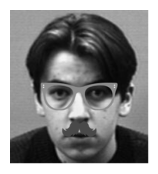

In [102]:
fig, axes = plt.subplots(figsize=(3, 2))
reshaped_image = X_new_1.reshape(image_size)
plt.imshow(reshaped_image, cmap='gray')
plt.axis('off')
plt.show()

In [103]:
Y_new_1_hat = pretrained_model.predict(X_new_1.reshape(1, -1))
Y_new_1_hat

array([3])

In [104]:
Y_new_1

3

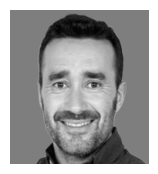

In [105]:
fig, axes = plt.subplots(figsize=(3, 2))
reshaped_image = X_new_2.reshape(image_size)
plt.imshow(reshaped_image, cmap='gray')
plt.axis('off')
plt.show()

In [106]:
Y_new_2_hat = pretrained_model.predict(X_new_2.reshape(1, -1))
Y_new_2_hat

array([0])

## **Face Recognition - PCA-KKN Algorithm**

### **Testing the functionality of the algorithm**

In [107]:
facial_recognition_knn_pca = FacialRecognitionKnnPca(n_neighbors=5, metric='euclidean', n_components=3, threshold_dist=0)
facial_recognition_knn_pca.fit(X_IN_train, Y_IN_train)
Y_val_hat = facial_recognition_knn_pca.predict(X_val)

In [108]:
Y_val

array([17., 19., 12., 16., 23.,  7.,  6., 24.,  5., 22., 15.,  2.,  7.,
        3.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.])

In [109]:
Y_val_hat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [110]:
# General accuracy
accuracy_score(y_pred=Y_val_hat, y_true=Y_val)

0.53125

In [111]:
# Accuracy for IN images
accuracy_score(y_pred=Y_val_hat[np.where(Y_val != 0)], y_true=Y_val[np.where(Y_val != 0)])

0.0

In [112]:
# Accuracy for OUT images
accuracy_score(y_pred=Y_val_hat[np.where(Y_val == 0)], y_true=Y_val[np.where(Y_val == 0)])

1.0

### **Hyperparameter tunning**

In [113]:
param_grid = dict()
param_grid['metric'] = ['euclidean','cosine','cityblock','manhattan']
param_grid['n_components'] = np.arange(1, 60, 3)
param_grid['threshold_dist'] = np.arange(0, 500, 5) 
param_grid['n_neighbors'] = range(1, 30)

FR_knn_pca_random_search = RandomSearchFacialRecognitionKnnPca(param_grid=param_grid, n_trials=50, random_state=123)
FR_knn_pca_random_search.fit(X_train=X_IN_train, Y_train=Y_IN_train, X_test=X_val, Y_test=Y_val)

In [114]:
FR_knn_pca_random_search.results

,combination,accuracy,accuracy_IN,accuracy_OUT,metric,n_components,threshold_dist,n_neighbors
12,"(cityblock, 31, 415, 2)",1.000,1.000,1.000,cityblock,31,415,2
48,"(cityblock, 10, 55, 4)",1.000,1.000,1.000,cityblock,10,55,4
35,"(manhattan, 19, 85, 7)",1.000,1.000,1.000,manhattan,19,85,7
29,"(manhattan, 58, 210, 10)",0.906,0.800,1.000,manhattan,58,210,10
47,"(cityblock, 34, 415, 9)",0.906,0.800,1.000,cityblock,34,415,9
37,"(euclidean, 28, 110, 11)",0.812,0.600,1.000,euclidean,28,110,11
7,"(manhattan, 46, 395, 18)",0.719,0.400,1.000,manhattan,46,395,18
43,"(manhattan, 34, 205, 24)",0.688,0.333,1.000,manhattan,34,205,24
20,"(cityblock, 31, 350, 23)",0.688,0.333,1.000,cityblock,31,350,23
27,"(manhattan, 28, 460, 24)",0.656,0.267,1.000,manhattan,28,460,24


In [115]:
FR_knn_pca_random_search.best_params_

{'n_neighbors': 2,
 'metric': 'cityblock',
 'n_components': 31,
 'threshold_dist': 415}

In [116]:
FR_knn_pca_random_search.best_score_

1.0

### **Estimation of future performance**

In [117]:
best_facial_recognition_knn_pca = FacialRecognitionKnnPca()
best_facial_recognition_knn_pca.set_params(**FR_knn_pca_random_search.best_params_)
best_facial_recognition_knn_pca.fit(X_IN_train, Y_IN_train)
Y_test_hat = best_facial_recognition_knn_pca.predict(X_test)
accuracy_score(y_pred=Y_test_hat, y_true=Y_test)

1.0

### **Pre-trained algorithm**

- Saving the pre-trained model:

In [118]:
joblib.dump(best_facial_recognition_knn_pca, "facial_recognition_knn_pca.joblib")

['facial_recognition_knn_pca.joblib']

- Loading the pre-trained model:

In [119]:
pretrained_model = joblib.load("facial_recognition_knn_pca.joblib")

- Loading new images:

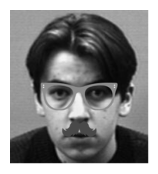

In [120]:
fig, axes = plt.subplots(figsize=(3, 2))
reshaped_image = X_new_1.reshape(image_size)
plt.imshow(reshaped_image, cmap='gray')
plt.axis('off')
plt.show()

In [121]:
Y_new_1_hat = pretrained_model.predict(X_new_1.reshape(1, -1))
Y_new_1_hat

array([3])

In [122]:
Y_new_1

3

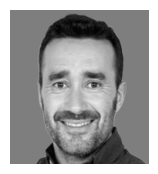

In [123]:
fig, axes = plt.subplots(figsize=(3, 2))
reshaped_image = X_new_2.reshape(image_size)
plt.imshow(reshaped_image, cmap='gray')
plt.axis('off')
plt.show()

In [124]:
Y_new_2_hat = pretrained_model.predict(X_new_2.reshape(1, -1))
Y_new_2_hat

array([0])

## **Face Recognition - Fisher-PCA-KKN Algorithm**

### **Testing the functionality of the algorithm**

In [125]:
facial_recognition_knn_pca_fisher = FacialRecognitionKnnPcaFisher(n_neighbors=5, metric='euclidean', n_components=100, threshold_dist=0)
facial_recognition_knn_pca_fisher.fit(X_IN_train, Y_IN_train)
Y_val_hat = facial_recognition_knn_pca_fisher.predict(X_val)

In [126]:
# General accuracy
accuracy_score(y_pred=Y_val_hat, y_true=Y_val)

0.53125

In [127]:
# Accuracy for IN images
accuracy_score(y_pred=Y_val_hat[np.where(Y_val != 0)], y_true=Y_val[np.where(Y_val != 0)])

0.0

In [128]:
# Accuracy for OUT images
accuracy_score(y_pred=Y_val_hat[np.where(Y_val == 0)], y_true=Y_val[np.where(Y_val == 0)])

1.0

### **Hyperparameter tunning**

In [129]:
param_grid = dict()
param_grid['metric'] = ['euclidean','cosine','cityblock','manhattan']
param_grid['n_components'] = np.arange(1, 60, 3)
param_grid['threshold_dist'] = np.arange(0, 500, 5) 
param_grid['n_neighbors'] = range(1, 30)

FR_knn_pca_fisher_random_search = RandomSearchFacialRecognitionKnnPcaFisher(param_grid=param_grid, n_trials=50, random_state=123)
FR_knn_pca_fisher_random_search.fit(X_train=X_IN_train, Y_train=Y_IN_train, X_test=X_val, Y_test=Y_val)

In [130]:
FR_knn_pca_fisher_random_search.results

,combination,accuracy,accuracy_IN,accuracy_OUT,metric,n_components,threshold_dist,n_neighbors
35,"(manhattan, 19, 85, 7)",1.000,1.000,1.000,manhattan,19,85,7
48,"(cityblock, 10, 55, 4)",1.000,1.000,1.000,cityblock,10,55,4
12,"(cityblock, 31, 415, 2)",0.938,1.000,0.882,cityblock,31,415,2
29,"(manhattan, 58, 210, 10)",0.875,0.733,1.000,manhattan,58,210,10
47,"(cityblock, 34, 415, 9)",0.844,1.000,0.706,cityblock,34,415,9
37,"(euclidean, 28, 110, 11)",0.750,0.667,0.824,euclidean,28,110,11
43,"(manhattan, 34, 205, 24)",0.688,0.333,1.000,manhattan,34,205,24
20,"(cityblock, 31, 350, 23)",0.656,0.267,1.000,cityblock,31,350,23
11,"(cityblock, 25, 230, 29)",0.625,0.200,1.000,cityblock,25,230,29
18,"(euclidean, 37, 100, 25)",0.625,0.267,0.941,euclidean,37,100,25


In [131]:
FR_knn_pca_fisher_random_search.best_params_

{'n_neighbors': 7,
 'metric': 'manhattan',
 'n_components': 19,
 'threshold_dist': 85}

In [132]:
FR_knn_pca_fisher_random_search.best_score_

1.0

### **Estimation of future performance**

In [133]:
best_facial_recognition_knn_pca_fisher = FacialRecognitionKnnPcaFisher()
best_facial_recognition_knn_pca_fisher.set_params(**FR_knn_pca_fisher_random_search.best_params_)
best_facial_recognition_knn_pca_fisher.fit(X_IN_train, Y_IN_train)
Y_test_hat = best_facial_recognition_knn_pca_fisher.predict(X_test)
accuracy_score(y_pred=Y_test_hat, y_true=Y_test)

0.8484848484848485

### **Pre-trained algorithm**

- Saving the pre-trained model:

In [134]:
joblib.dump(best_facial_recognition_knn_pca, "facial_recognition_knn_pca_fisher.joblib")

['facial_recognition_knn_pca_fisher.joblib']

- Loading the pre-trained model:

In [135]:
pretrained_model = joblib.load("facial_recognition_knn_pca_fisher.joblib")

- Loading new images:

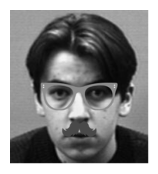

In [136]:
fig, axes = plt.subplots(figsize=(3, 2))
reshaped_image = X_new_1.reshape(image_size)
plt.imshow(reshaped_image, cmap='gray')
plt.axis('off')
plt.show()

In [137]:
Y_new_1_hat = pretrained_model.predict(X_new_1.reshape(1, -1))
Y_new_1_hat

array([3])

In [138]:
Y_new_1

3

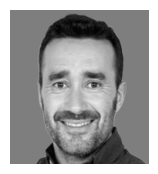

In [139]:
fig, axes = plt.subplots(figsize=(3, 2))
reshaped_image = X_new_2.reshape(image_size)
plt.imshow(reshaped_image, cmap='gray')
plt.axis('off')
plt.show()

In [140]:
Y_new_2_hat = pretrained_model.predict(X_new_2.reshape(1, -1))
Y_new_2_hat

array([0])